# Computer Vision (911.908)

## <font color='crimson'>Finetuning</font>

**Changelog**:
- *Sep. 2021*: initial version
- *Jan. 2023*: adaptations to PyTorch 1.13.1

---

In this part of the lecture, we cover the topic of *model fine-tuning*, using a neural network, pre-trained for a different task than the one we want to solve. In particular, we look at an approach that only modifies the **final layer** (i.e., the classifier) of a neural network.

In [1]:
%matplotlib inline

import numpy as np

import torch
from torch import nn
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
import torch.nn.functional as F 

import copy
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
print(torch.__version__)

1.13.0+cu117


---
## Content

- [Loading and testing pretrained models](#Loading-and-testing-pretrained-models)
- [Finetuning pretrained models on a new dataset](#Finetuning-pretrained-models-on-a-new-dataset)
- [Comparison to training from scratch](#Comparison-to-training-from-scratch)

---

Below are some helper functions that we will use later on.

In [3]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Loading and testing pretrained models


### Loading pretrained ResNets

Lets actually look at the final ResNet-18/36/... architecture:

https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

and load a **pretrained** (on ImageNet-1000) ResNet-18 network.

In [4]:
#model = resnet18(pretrained=True) old way

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

The ResNet was trained on $224 \times 224$ images that were mean-subtracted and normalized by the standard deviation. So, in order to use this network on our own data, we have to resize an input image to $224 \times 224$, and subtract the dataset (i.e., the ImageNet) mean and divide by the standard deviation. Fortunately, the `torchvision` package allows us to do this easily.

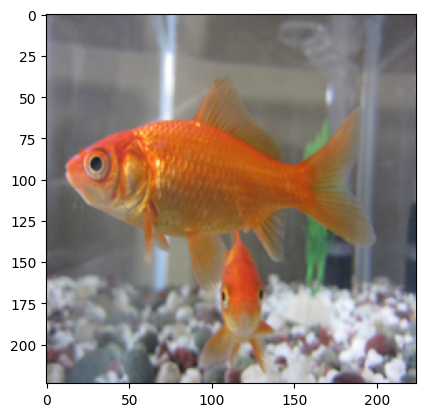

In [6]:
im = Image.open('goldfish.jpg')
plt.imshow(im.resize((224,224)))

### ImageNet-1000 meta-data

First, we fetch a textual description of all **1000** ImageNet classes from the web.

In [7]:
classes = pickle.load(
    urlopen(
        'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

# lets print the first 10 descriptions / labels
for idx in range(10):
    print(idx, classes[idx])

0 tench, Tinca tinca
1 goldfish, Carassius auratus
2 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
3 tiger shark, Galeocerdo cuvieri
4 hammerhead, hammerhead shark
5 electric ray, crampfish, numbfish, torpedo
6 stingray
7 cock
8 hen
9 ostrich, Struthio camelus


### Instantiating the required transforms

Next, we instantiate a transform (actually a composition of transforms) that take an image, resizes it to $226 \times 256$ pixel, then extracts a $224 \times 224$ center crop, normalizes the channes to the range $[0,1]$, and finally subtracts the channel mean and standard deviation. This is required, as the pretrained ImageNet model was trained on $224 \times 224$ images and thus expects this input size. The mean/std. dev. setting is also the one used for the pretrained model.

In [8]:
tr = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

We are now ready to apply the model. We first set the model to *evaluation* mode (makes sure the BatchNorm parameters found during training are used).

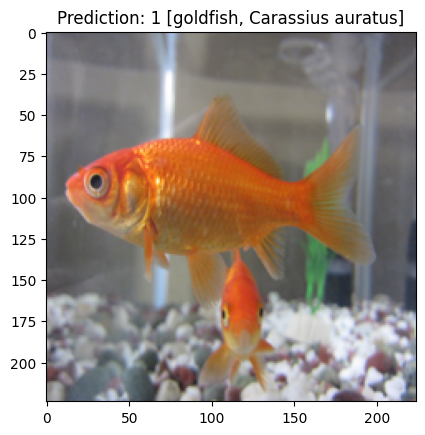

In [9]:
inp = tr(im).unsqueeze(0)
model.eval()
out = model(inp)

plt.imshow(im.resize((224,224)));
plt.title('Prediction: {} [{}]'.format(out.argmax().item(), classes[out.argmax().item()]));

## Finetuning pretrained models on a new dataset

Next, we discuss how to adjust a pretrained model (e.g., a ResNet-18) to a new task. In particular, we take a ResNet-18, trained on ImageNet-1000 (from above), and fine-tune it to distinguish between *ants* and *bees* (i.e., a two-class classification problem).

First, we create a copy of our model; all the information, e.g., weights, etc., are stored
in a dictionary, called the *state dictionary*, that is accessible via `state_dict()`.

In [10]:
simp_model_state_dict = copy.deepcopy(model.state_dict())

Now, we are ready to create a dataset from our ants/bees image folder and instantiate a data loader using that dataset.

In [11]:
bees_ants = torchvision.datasets.ImageFolder(
    '/lab/ai/rkwitt/teaching/WS2122/CV/material/data/hymenoptera_data/train/', 
    transform=tr)

data_loader = torch.utils.data.DataLoader(bees_ants,
                                          batch_size=16, # use mini-batches of size 16
                                          shuffle=True,  # shuffle batches during training
                                          num_workers=1) # use one thread for loading

print('Nr. of images in beets-vs-ants dataset: {}'.format(len(bees_ants)))

Nr. of images in beets-vs-ants dataset: 244


Lets fetch a batch of samples and visualize the images.

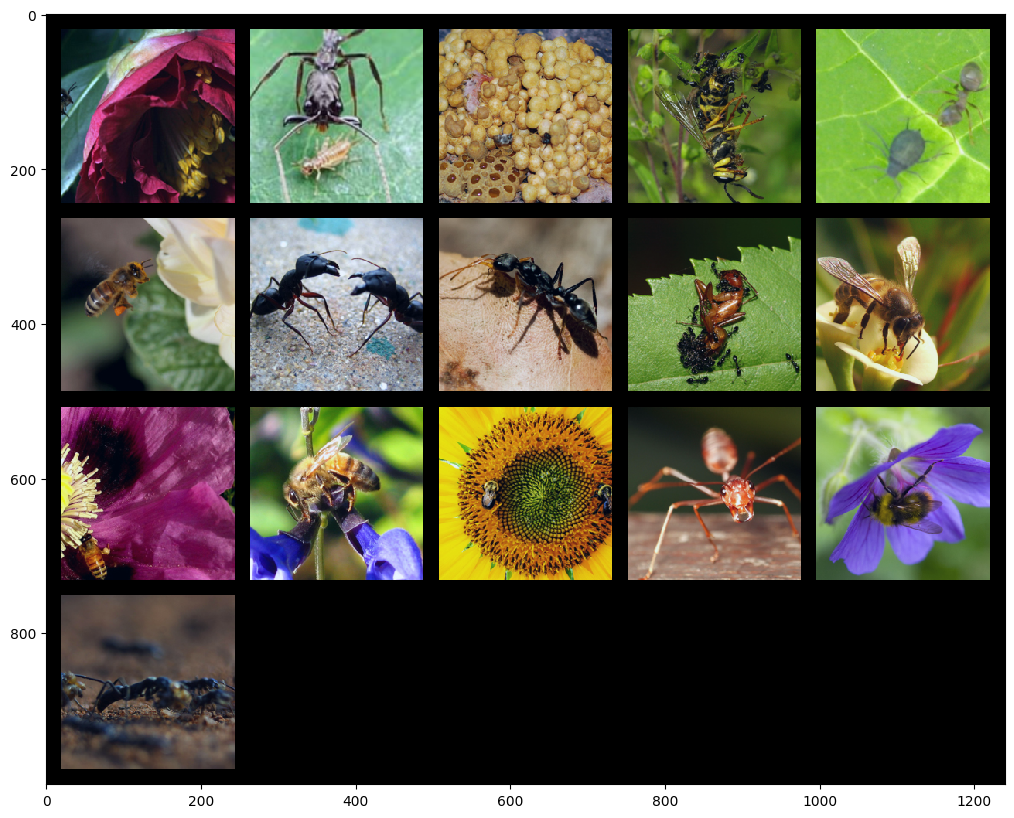

In [12]:
# get a batch from the data loader
X = next(iter(data_loader))[0]
# use PyTorch's make_grid function to construct a large matrix holding the image data
grid = torchvision.utils.make_grid(X, nrow=5, normalize=True, padding=20)
plt.figure(figsize=(20,10))
show(grid)

We will also create a dictionary that holds a mapping of class indices (0,1) to class names.

In [13]:
idx_to_cls = {bees_ants.class_to_idx[k]: k for k in bees_ants.class_to_idx.keys()}
print(idx_to_cls)

{0: 'ants', 1: 'bees'}


Our method for fine-tuning will simply be to replace the last linear layer (fully-connected layer) of our model with a new one that fits our needs. Here, we have a **2-class problem**, so we need a linear layer with 2 outputs.

Further, we **do not** want to update all the model parameters, we just want the last layer to adapt to our 2-class problem. Hence, we set all other parameters to `requires_grad=False`. We will write a short function that does this for us.

In [14]:
def freeze_model(model):
    # iterate over all parameters and set requires_grad to False
    for param in model.parameters(): 
        param.requires_grad = False  

So, lets replace the last layer of our pretrained model!

In [15]:
simp_model = resnet18()                           # instantiate ResNet-18 model
simp_model.load_state_dict(simp_model_state_dict) # load state-dict from pretrained model
freeze_model(simp_model)                          # freeze all model paramters
simp_model.fc = nn.Linear(simp_model.fc.in_features, 2) # replace FC layer

print(simp_model.fc.weight.requires_grad)

True


At this point, **only the replaced layer** will have `requires_grad=True` (default), so we can iterate over all parametes and collect those where `requires_grad` is `True`. We add these parameters to a list.

In [16]:
params_to_update = []
for name,param in simp_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias


We now have a pre-trained model with all layers, except the last one, frozen. Hence, we can start training. For that, we need an optimizer and a loss. We use SGD with **momentum** here and the commonly-used cross-entropy loss.

In [17]:
DEVICE = 'cuda:0'

n_epochs = 20
opt = torch.optim.SGD(params_to_update, lr=1e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()

simp_model.to(DEVICE)
simp_model.train()

iteration_losses = []
for i in range(n_epochs):
    e_loss = 0
    
    for x,y in data_loader:
        
        x = x.to(DEVICE) 
        y = y.to(DEVICE) 
        
        simp_model.zero_grad()    # zero-out gradients
        out = simp_model(x)       # forward pass
        loss = criterion(out, y)  # compute loss
        e_loss += loss.item()     # track loss (optional)
        iteration_losses.append(loss.item())
        loss.backward()           # compute gradients via backprop.
        opt.step()                # take an optimizer step

    print('Epoch {:4d}: {:.4f}'.format(i, e_loss))

Epoch    0: 11.9784
Epoch    1: 10.5147
Epoch    2: 9.3852
Epoch    3: 8.5513
Epoch    4: 7.8281
Epoch    5: 7.1690
Epoch    6: 6.7222
Epoch    7: 6.4043
Epoch    8: 5.8601
Epoch    9: 5.8495
Epoch   10: 5.7390
Epoch   11: 5.3940
Epoch   12: 5.1117
Epoch   13: 4.7749
Epoch   14: 5.1596
Epoch   15: 4.7824
Epoch   16: 4.8280
Epoch   17: 4.5171
Epoch   18: 4.4530
Epoch   19: 3.9884


### Evaluation

Image 00 | Class: ants
Image 01 | Class: bees
Image 02 | Class: ants
Image 03 | Class: ants
Image 04 | Class: ants
Image 05 | Class: bees
Image 06 | Class: ants
Image 07 | Class: ants
Image 08 | Class: ants
Image 09 | Class: ants
Image 10 | Class: bees
Image 11 | Class: bees
Image 12 | Class: bees
Image 13 | Class: ants
Image 14 | Class: bees
Image 15 | Class: bees


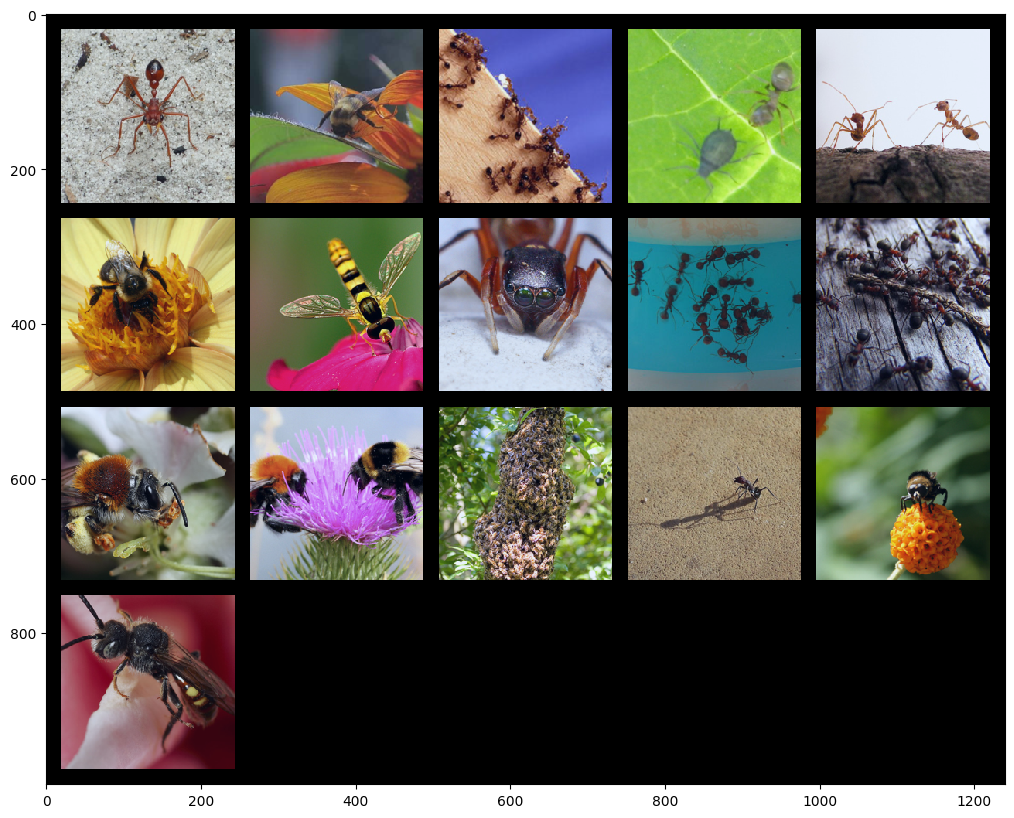

In [18]:
simp_model.eval()

X = next(iter(data_loader))[0]
X = X.to(DEVICE)
output = simp_model(X)
output = F.softmax(output,dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
for img_i, label in enumerate(list(pred_label_idx.cpu())):
    print('Image {:02d} | Class: {}'.format(img_i, idx_to_cls[label.item()]))

grid = torchvision.utils.make_grid(X.cpu(), nrow=5, normalize=True, padding=20)
plt.figure(figsize=(20,10))
show(grid)

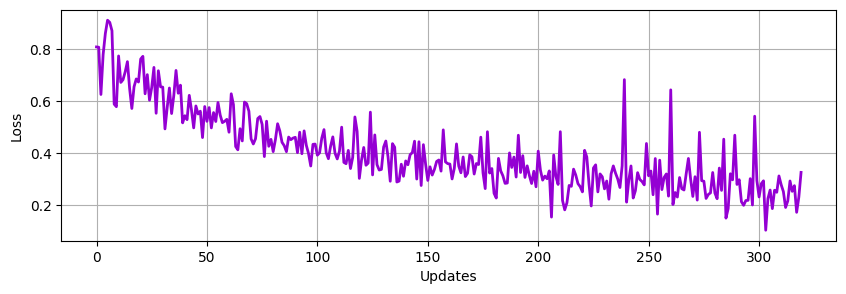

In [22]:
plt.figure(figsize=(10,3))
plt.plot(iteration_losses, linewidth=2, color='darkviolet')
plt.xlabel('Updates')
plt.ylabel('Loss');
plt.axis('tight')
plt.grid()

## Comparison to training from scratch

As a check to see if fine-tuning actually does a better job than simply training a ResNet-18 from scratch, lets just do this.

In [23]:
model_from_scratch = resnet18()
model_from_scratch.fc = nn.Linear(model_from_scratch.fc.in_features,2)
opt = torch.optim.SGD(model_from_scratch.parameters(), lr=0.001, momentum=0.9)

model_from_scratch.to(DEVICE)
model_from_scratch.train()

# Run over a couple of epochs
for i in range(30):
    e_loss = 0
    
    # Run over all batches of training data for ants/bees
    for x,y in data_loader:
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        model_from_scratch.zero_grad()    # zero gradients
        out = model_from_scratch(x)       # forward pass
        loss = criterion(out, y)  # compute loss
        e_loss += loss.item()     # track loss (optional)
        loss.backward()           # compute gradients via backprop.
        opt.step()                # take an optimizer step

    print('Epoch {}: {:.4f}'.format(i, e_loss))

Epoch 0: 10.6510
Epoch 1: 10.5639
Epoch 2: 9.4238
Epoch 3: 9.7544
Epoch 4: 9.9168
Epoch 5: 11.6153
Epoch 6: 9.3113
Epoch 7: 8.0917
Epoch 8: 8.6782
Epoch 9: 7.3969
Epoch 10: 7.0067
Epoch 11: 6.7227
Epoch 12: 7.7717
Epoch 13: 5.9837
Epoch 14: 6.3605
Epoch 15: 5.2687
Epoch 16: 5.3454
Epoch 17: 5.0437
Epoch 18: 4.0321
Epoch 19: 3.9947
Epoch 20: 3.5638
Epoch 21: 4.8224
Epoch 22: 3.1549
Epoch 23: 3.2494
Epoch 24: 1.6798
Epoch 25: 2.1362
Epoch 26: 2.7679
Epoch 27: 2.7597
Epoch 28: 2.0112
Epoch 29: 1.4413


### Evaluation of fine-tuned and trained-from-scratch models on validation set

In [24]:
def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    for x,y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == y.data)

    print("Accuracy: {:.3f} [%]".format(float(running_corrects)/len(bees_ants_val)*100.0))

In [25]:
bees_ants_val = torchvision.datasets.ImageFolder('/lab/ai/rkwitt/teaching/WS2122/CV/material/data/hymenoptera_data/val/',
                                            transform=tr)
data_loader_val = torch.utils.data.DataLoader(bees_ants_val,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=1)

In [26]:
evaluate(simp_model, data_loader_val)
evaluate(model_from_scratch, data_loader_val)

Accuracy: 92.810 [%]
Accuracy: 71.895 [%]


We see that training from scratch on this rather small dataset, we **heavily** overfit to the data (training loss is comparable -- actually less than the finetuned model -- but validation accuracy is far off). In case of fine-tuning, we only adjust the final layer (i.e., $512 \times 2$ parameters), whereas when training from scratch we adjust all model parameters.

### Comparing the number of trainable parameters

In [27]:
n_params = 0
for p in model_from_scratch.parameters(): n_params+=p.numel()
print('Nr. of ResNet-18 model paramters: {}'.format(n_params))
print('Nr. of trainable parameters for finetuning {}'.format(simp_model.fc.weight.numel()+2))

Nr. of ResNet-18 model paramters: 11177538
Nr. of trainable parameters for finetuning 1026


### Filter visualization

Out of curiosity, lets visualize the learned filters in the **first** conv. layer of the ResNet18 model.

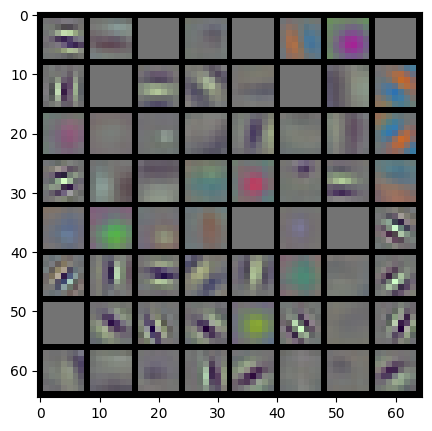

In [28]:
grid = torchvision.utils.make_grid(simp_model.conv1.weight.data.cpu(), nrow=8, normalize=True, padding=1)
plt.figure( figsize=(5,5) )
plt.imshow(grid.numpy().transpose((1, 2, 0)))

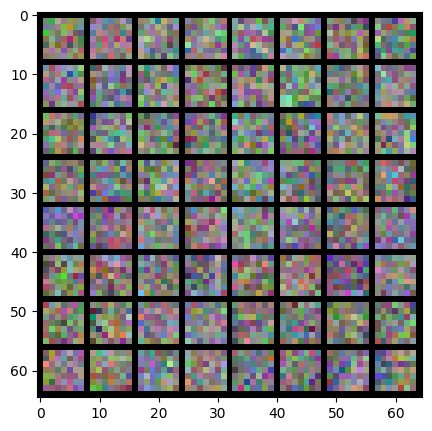

In [29]:
grid = torchvision.utils.make_grid(model_from_scratch.conv1.weight.data.cpu(), nrow=8, normalize=True, padding=1)
plt.figure( figsize=(5,5) )
plt.imshow(grid.numpy().transpose((1, 2, 0)))